In [675]:
from __future__ import print_function
import csv
import importlib.util
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Draw
from rdkit.Chem import Crippen
from rdkit.Chem import Lipinski
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import GraphDescriptors
from rdkit.Chem.Descriptors import ExactMolWt
from enum import Enum
import numpy as np
import scipy.stats as stats
import statistics
import math
import string
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import bottchercomplexity as bcf
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.8
plt.rcParams['font.size'] = 12
plt.rc('text', usetex=True)

ModuleNotFoundError: No module named 'bottchercomplexity'

In [ ]:
#####################
#                   #
# Loading Resources #
#                   #
#####################

In [559]:
cols = ['Barcode','Researcher','Notebook','Page','Smiles','Comments','MW(amu)','MPLOWER','MPUPPER','CardMissing','Notes','LabelNotes']
poster_data = pd.read_csv("MIKI/BurckhalterDatabase.csv", engine='python', names=cols)
new_data = pd.read_csv("BurckhalterDatabase.csv", engine='python', names=cols)
cmld_data = pd.read_csv("MIKI/cmld.csv")

In [ ]:
#####################
#                   #
#  Data Interfaces  #
#                   #
#####################

In [666]:
class LibraryError(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

class Library:
    def __init__(self, data):
        self.raw_data = data
        self.smiles = self.smilesToList()
        self.molecules = []
        for entry in self.smiles:
            if entry is not None:
                temp = Chem.MolFromSmiles(entry)
                if temp is not None:
                    self.molecules.append(temp)
        self.molecular_weights = self.getMolecularWeights()
        self.avgSim, self.fpstdev, self.similarities = self.compareAllFingerprints()
        self.avgComp, self.compstdev, self.complexities = self.getAllComplexities()
        self.avgclogp, self.clogpstdev, self.clogps = self.getAllClogps()
        self.avghdonors, self.avghdonors, self.hdonors = self.getHDonors()
        self.avghacceptors, self.avghacceptors, self.hacceptors = self.getHAcceptors()

    def __filterSmiles():
        return None

    def smilesToList(self):
        smiles_processed = []
        temp = self.raw_data.dropna(subset=['Smiles']).reset_index(drop=True)['Smiles'].to_list()
        # Filter Errors
        for i in temp:
            if ' ' in i.strip(' ') or len(i) == 0: pass
            else: smiles_processed.append(i)
        return smiles_processed

    def compareAllFingerprints(self):
        fprints = [FingerprintMols.FingerprintMol(x) for x in self.molecules]
        fpcompare = []
        for i in range(1, len(fprints)):
            fpcompare.append(DataStructs.FingerprintSimilarity(fprints[0],fprints[i]))
        tempavgSim = 0
        for i in fpcompare:
            tempavgSim += i
        corrected = []
        for i in fpcompare:
            corrected.append(i*100)
        return (tempavgSim/(len(fprints)-1)), statistics.stdev(corrected), corrected

    def getAllClogps(self):
        clogps = []
        for i in self.molecules:
            clogps.append(Crippen.MolLogP(i))
        avg = 0
        for i in clogps:
            avg += i / (len(clogps))
        stddev = statistics.stdev(clogps)
        return avg, stddev, clogps;

    def getMolecularWeights(self):
        temp = []
        for i in self.molecules:
            temp.append(ExactMolWt(i))
        return temp

    def getAllComplexities(self):
        complexities = []
        for i in self.molecules:
            complexities.append(Chem.GraphDescriptors.BertzCT(i))
        avg = 0
        for i in complexities:
            avg += i/(len(complexities))
        stddev = statistics.stdev(complexities)
        return avg, stddev, complexities

    def getComplexityStats(self):
        return self.avgComp, self.compstdev, self.complexities

    def getClogPStats(self):
        return self.avgclogp, self.clogpstdev, self.clogps
    
    def getFingerprintSimilarityAverage(self):
        x_axis = np.arange(-10, 100, 1)
        plt.plot(x_axis, stats.norm.pdf(x_axis, self.avgSim*100, self.fpstdev))

    def getFingerprintSimilarityHistogram(self, bins=50):
        plt.hist(self.similarities, bins=bins, histtype='barstacked', density=True)

    def getHDonors(self):
        hdonors = []
        for i in self.molecules:
            hdonors.append(Lipinski.NumHDonors(i))
        avg = 0
        for i in hdonors:
            avg += i/(len(hdonors))
        stddev = statistics.stdev(hdonors)
        return avg, stddev, hdonors

    def getHAcceptors(self):
        hacceptors = []
        for i in self.molecules:
            hacceptors.append(Lipinski.NumHAcceptors(i))
        avg = 0
        for i in hacceptors:
            avg += i/(len(hacceptors))
        stddev = statistics.stdev(hacceptors)
        return avg, stddev, hacceptors

    def getWeight(self):
        avg = 0
        for i in self.molecular_weights:
            avg += i/(len(self.molecular_weights))
        stddev = statistics.stdev(self.molecular_weights)
        return avg, stddev, self.molecular_weights


    def __repr__(self):
        return "Library"

    # Pandas Dataframes
    raw_data = None

    # Lists
    smiles = None
    molecules = None
    molecular_weights = None
    similarities = None
    complexities = None
    clogps = None
    hdonors = None
    haccptors = None

    # Numbers
    avghdonors = None
    hdonorstdev = None

    avghacceptors = None
    hacceptorstdev = None

    avgSim = None
    fpstdev = None

    avgComp = None
    compstdev = None

    avgWeight = None
    weightstdev = None

    avgclogp = None
    clogpstdev = None


In [653]:
class BurckData:
    def __init__(self, poster_data, new_data, cmld_data):

        if(isinstance(poster_data, Library)):
            self.poster_lib = poster_data
        else:
            self.poster_lib = Library(poster_data)
        if(isinstance(new_data, Library)):
            self.new_lib = new_data
        else:
            self.new_lib = Library(new_data)
        if(isinstance(cmld_data, Library)):
            self.cmld_lib = cmld_data
        else:
            self.cmld_lib = Library(cmld_data)

    def fmtTitle(self, titlestr, liblbl, nummols):
            title = titlestr + " in "
            if liblbl == 'MIKI':
                title = title + " the "
            else:
                title = title + " a "
            title = title + str(nummols) + "-Member " + liblbl + " Subset"
            return title

    def getLib(self, lib):
        if lib == 'poster':
            return self.poster_lib, "MIKI"
        elif lib == 'burck':
            return self.new_lib, "BHC"
        elif lib == 'cmld':
            return self.cmld_lib, "CMLDC"
        else:
            raise LibraryError("Could not find library.")

    def getSmiles(self, lib):
        try:
            temp = self.getLib(lib).smiles
            return temp
        except LibraryError:
            print("Got it!")

    def getMolecules(self, lib):
        try:
            temp = self.getLib(lib).molecules
            return temp
        except LibraryError:
            print("Got it!")

    def getNumSmiles(self, lib):
        try:
            temp = self.getLib(lib).smiles
            return len(temp)
        except LibraryError:
            print("Aborting...")

    def getNumMolecules(self, lib):
        try:
            temp = self.getLib(lib).molecules
            return len(temp)
        except LibraryError:
            print("Aborting...")

    def validatedMolToCsv(self, lib):
        """Return a CSV representation of every molecule in the library if and only if RDKIT
        was able to process it."""
        pass

    def getFunction(self, lib, param):
        if(param == 'weight'):
            return lib.getWeight()
        elif(param == 'hacceptors'):
            return lib.getHAcceptors()
        elif(param == 'hdonors'):
            return lib.getHDonors()
        elif(param == 'clogps'):
            return None

    def __getHistogram(self, lib, param, ax, **kwargs):
        temp, liblbl = self.getLib(lib)
        avg, stdev, param = self.getFunction(temp, param)
        ax.hist(param, histtype='barstacked',
                bins= kwargs['bins'] if 'bins' in kwargs else max(param) if max(param) < 50 else 50,
                density = kwargs['density'] if 'density' in kwargs else True,
                alpha = float(kwargs['alpha']) if 'alpha' in kwargs else 1,
                label=liblbl,
                align='mid')
        if(kwargs['inc_title'] if 'inc_title' in kwargs else False):
            ax.set_title(self.fmtTitle(kwargs['title'] if 'title' in kwargs else "MISSING TITLE", liblbl, len(param)))
        if param == 'hacceptors' or param == 'hdonors':
            xrange = np.arange(0, math.ceil(max(param))+1, 1)
            ax.set_xticks(xrange)
        ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else "MISSING XLABEL")
        ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else "MISSING YLABEL")

    def getHistogram(self, lib, param, ax, **kwargs):
        try:
            if(isinstance(lib, list)):
                for entry in lib:
                    self.__getHistogram(entry, param, ax, **kwargs)
            else:
                self.__getHistogram(lib, param, ax, **kwargs)
        except LibraryError:
            pass

    def __getBoxplot(self, lib, param, ax, **kwargs):
        temp, liblbl = self.getLib(lib)
        avg, stdev, values = self.getFunction(temp, param)
        ax.boxplot(values,
                   vert=kwargs['vert'] if 'vert' in kwargs else False,
                   showfliers=kwargs['showfliers'] if 'showfliers' in kwargs else False)

        if(kwargs['mask_outliers'] if 'mask_outliers' in kwargs else True):
            upper_quartile = np.percentile(values, 75) + (kwargs['mask_offset'] if 'mask_offset' in kwargs else 1)
            outlier_mask = [value for value in values if value > upper_quartile]
            x = np.random.normal(1, 0.04, size=len(outlier_mask))
            ax.scatter(outlier_mask, x, alpha=0.2)
        if(kwargs['title'] if 'title' in kwargs else False):
            ax.set_title(self.fmtTitle(kwargs['title'] if 'title' in kwargs else "MISSING TITLE", liblbl, len(param)))
        if param == 'hacceptors' or param == 'hdonors':
            xrange = np.arange(0, math.ceil(max(values))+1, 1)
            ax.set_xticks(xrange)
        ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else None)
        ax.set_yticklabels([kwargs['ylabel']] if 'ylabel' in kwargs else [liblbl], rotation=45)

    def getBoxplot(self, lib, param, ax, **kwargs):
        try:
            if(isinstance(lib, list)):
                for entry in lib:
                    self.__getBoxplot(entry, param, ax, **kwargs)
            else:
                self.__getBoxplot(lib, param, ax, **kwargs)
        except LibraryError:
            pass


    def getWeightBoxplot(self, lib, path=None, **kwargs):
            try:
                temp, liblbl = self.getLib(lib)
                weights = temp.molecular_weights
                fig = plt.figure()
                plt.boxplot(weights, vert=kwargs['vert'] if 'vert' in kwargs else False)
                plt.title(self.fmtTitle("Distribution of Molecular Weights", liblbl, len(weights)))
                plt.xlabel("Molecular Weight (amu)")
                plt.ylabel("Number of Molecules in Bin")
            except LibraryError:
                pass

    def getSimilarityDistribution(self, lib, path=None):
        try:
            temp, liblbl = self.getLib(lib)
            temp.getFingerprintSimilarityAverage()
            title = "Similarity Between Molecule 1 and Others in "
            plt.title(self.fmtTitle("Similarity Between Molecule 1 and Others", liblbl, len(temp.molecules)))
            plt.xlabel("Similarity Score")
            plt.ylabel("Fraction of Molecules with Score")
            if path is not None:
                plt.savefig(path)
        except LibraryError:
            pass

    def getComplexityDistribution(self, lib, path=None):
        try:
            temp, liblbl = self.getLib(lib)
            avg, stdev, complexities = temp.getComplexityStats()
            x_axis = np.arange(-1000, 3000, 1)
            fig = plt.figure()
            plt.plot(x_axis, stats.norm.pdf(x_axis, avg, stdev))
            plt.title(self.fmtTitle("Complexity Distribution of Molecules", liblbl, len(complexities)))
            plt.xlabel("Complexity")
            plt.ylabel("Fraction of Molecules with Score")
            if path is not None:
                plt.savefig(path)
        except LibraryError:
            pass

    def getClogPDistribution(self, lib, **kwargs):
        try:
            temp, liblbl = self.getLib(lib)
            avg, stdev, clogps = temp.getClogPStats()
            x_axis = np.arange(-10, 20, 1)
            fig = plt.figure()
            plt.plot(x_axis, stats.norm.pdf(x_axis, avg, stdev))
            plt.title(self.fmtTitle("CLogP values of Molecules", liblbl, len(clogps)))
            plt.xlabel("clogp")
            plt.ylabel("Fraction of Molecules with Score")
            if path in kwargs:
                plt.savefig(path)
        except LibraryError:
            pass

    def getClogPHistogram(self, lib, path=None):
        try:
            temp, liblbl = self.getLib(lib)
            avg, stdev, clogps = temp.getClogPStats()
            x_axis = np.arange(-10, 100, 1)
            fig = plt.figure()
            plt.hist(clogps, bins=50, histtype='barstacked')
            plt.title(self.fmtTitle("Histogram of CLogP values", liblbl, len(clogps)))
            plt.xlabel("clogp")
            plt.ylabel("Fraction of Molecules with Score")
            if path is not None:
                plt.savefig(path)
        except LibraryError:
            pass

    def getHDonorBoxplot(self, lib, ax, **kwargs):
        try:
            temp, liblbl = self.getLib(lib)
            avg, stdev, hdonors = temp.getHDonors()
            upper_quartile = np.percentile(hdonors, 75) + 1
            ax.boxplot(hdonors,
                       vert=kwargs['vert'] if 'vert' in kwargs else False,
                       showfliers=False)
            hdonors_mask = [hdonor for hdonor in hdonors if hdonor > upper_quartile]
            x = np.random.normal(1, 0.04, size=len(hdonors_mask))
            ax.scatter(hdonors_mask, x, alpha=0.2)
            if(kwargs['title'] if 'title' in kwargs else False):
                ax.set_title(self.fmtTitle("Box-and-Whisker Plot of H-Donors Possessed by Molecules", liblbl, len(hdonors)))
            xrange = np.arange(0, math.ceil(max(hdonors))+1, 1)
            ax.set_xticks(xrange)
            # ax.set_xlabel("Number of H-Donors")
            ax.set_yticklabels([liblbl], rotation = 45)
        except LibraryError:
            pass

    def getHDonorHistogram(self, lib, ax, **kwargs):
        try:
            temp, liblbl = self.getLib(lib)
            avg, stdev, hdonors = temp.getHDonors()
            ax.hist(hdonors, bins=max(hdonors), histtype='barstacked',
                    density = kwargs['density'] if 'density' in kwargs else True,
                    alpha = float(kwargs['alpha']) if 'alpha' in kwargs else 1,
                    label=liblbl,
                    align='mid')
            if(kwargs['title'] if 'title' in kwargs else False):
                ax.set_title(self.fmtTitle("Histogram of H-Donors Possessed by Molecules", liblbl, len(hdonors)))
            xrange = np.arange(0, math.ceil(max(hdonors))+1, 1)
            ax.set_xticks(xrange)
            ax.set_xlabel("Number of H-Donors")
            ax.set_ylabel("Fraction of Molecules with Score")
        except LibraryError:
            pass

    def getHAcceptorBoxplot(self, lib, ax, **kwargs):
        try:
            temp, liblbl = self.getLib(lib)
            avg, stdev, hacceptors = temp.getHAcceptors()
            upper_quartile = np.percentile(hacceptors, 75) + 3
            ax.boxplot(hacceptors,
                       vert=kwargs['vert'] if 'vert' in kwargs else False,
                       showfliers=False)
            hacceptor_mask = [hacceptor for hacceptor in hacceptors if hacceptor > upper_quartile]
            x = np.random.normal(1, 0.04, size=len(hacceptor_mask))
            ax.scatter(hacceptor_mask, x, alpha=0.2)
            if(kwargs['title'] if 'title' in kwargs else False):
                ax.set_title(self.fmtTitle("Box-and-Whisker Plot of H-Acceptors Possessed by Molecules", liblbl, len(hacceptors)))
            xrange = np.arange(0, math.ceil(max(hacceptors))+1, 1)
            ax.set_xticks(xrange)
            # ax.set_xlabel("Number of H-Acceptors")
            ax.set_yticklabels([liblbl], rotation = 45)
        except LibraryError:
            pass

    def getHAcceptorHistogram(self, lib, ax, **kwargs):
        try:
            temp, liblbl = self.getLib(lib)
            avg, stdev, hacceptors = temp.getHAcceptors()
            ax.hist(hacceptors, bins=max(hacceptors), histtype='barstacked',
                    density = kwargs['density'] if 'density' in kwargs else True,
                    alpha = float(kwargs['alpha']) if 'alpha' in kwargs else 1,
                    label=liblbl)
            if(kwargs['title'] if 'title' in kwargs else False):
                ax.set_title(self.fmtTitle("Histogram of H-Acceptors Possessed by Molecules", liblbl, len(hacceptors)))
            ax.set_xlabel("Number of H-Acceptors")
            xrange = np.arange(0, math.ceil(max(hacceptors))+1, 1)
            ax.set_xticks(xrange)
            ax.set_ylabel("Fraction of Molecules with Score")
        except LibraryError:
            pass

    # Libraries
    poster_lib = None
    new_lib = None
    cmld_lib = None


In [562]:
class PIDGINData:
    def __init__(self, data, cmdline_output):
        self.raw_data_file = data
        self.cmdline_out = cmdline_output
        self.rejected_smiles = []
        self.rejected_smiles_indices = []
        results = []
        with open(data, 'r') as f:
            for line in f:
                results.append(line)
        for index, line in enumerate(results):
            results[index] = line.replace('\n', '').split('\t')
        temp = pd.DataFrame(results)
        self.processed_data = temp.rename(columns=temp.iloc[0]).drop(temp.index[0]).reset_index(drop=True)
        self.total_processed = 0
        with open(cmdline_output, 'r') as f:
            for line in f:
                tokenized_line = line.split(' ')
                if (len(tokenized_line) > 1) and (tokenized_line[1] == 'SMILES'):
                    self.rejected_smiles_indices.append(tokenized_line[-5])
                    self.rejected_smiles.append(tokenized_line[-1])
                if (len(tokenized_line) > 1) and (tokenized_line[1] == 'Processing'):
                    self.total_processed = tokenized_line[-1].strip('\n')
        self.processed_data = self.processed_data.replace('nan', np.NaN)

    def getActivityByName(self, mol_name, threshold = 0.0):
        try:
            rows = self.processed_data[mol_name].dropna().index.tolist()
            this_drug = self.processed_data.iloc[rows]
            metadata = this_drug.loc[:,'Uniprot':'Model_ID'].copy(deep=True)
            metadata[mol_name] = this_drug[mol_name]
            return metadata
        except KeyError:
            print("Molecule " + mol_name + " not found. It was probably rejected by PIDGIN.")
            return None

    raw_data_file = None
    processed_data = 0
    cmdline_out = None
    rejected_smiles = None
    rejected_smiles_indices = None
    total_processed = None


In [ ]:
#burck = PIDGINData()
drugs = PIDGINData("drugs_pred.txt", "drugs_cmdline_output.txt")
#cmld = PIDGINData()

In [667]:
poster = Library(poster_data)
burck = Library(new_data)
cmld = Library(cmld_data)

In [664]:
libraries = BurckData(poster, burck, cmld)

In [ ]:
##########################################
#                                        #
# Compound Collection Figures Start Here #
#                                        #
##########################################

In [ ]:
fig, axs = plt.subplots(4,1,figsize=(10,12), sharex=True)
axs[0].xaxis.set_tick_params(which='both', labelbottom='True')
axs[1].xaxis.set_tick_params(which='both', labelbottom='True')
gs = axs[1].get_gridspec()
for ax in axs[2:]:
    ax.remove()
axbig = fig.add_subplot(gs[2:])
plt.suptitle("H-Bond Donors in Burckhalter and CMLD", x=0.5, y=0.9)
libraries.getHDonorBoxplot('burck', axs[0])
libraries.getHDonorBoxplot('cmld', axs[1])
libraries.getHDonorHistogram('burck', axbig, alpha=0.5)
libraries.getHDonorHistogram('cmld', axbig, alpha=0.5)
axbig.legend()
plt.savefig("combined.png", dpi=150)


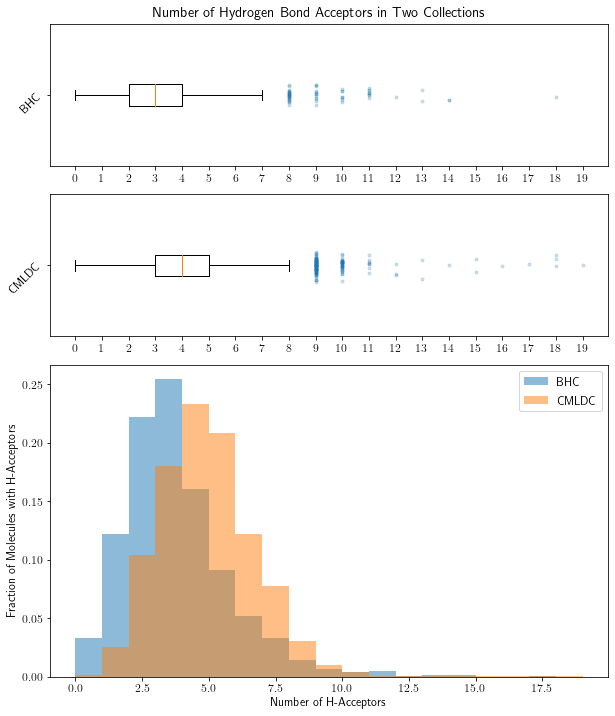

In [656]:
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
axs[0].xaxis.set_tick_params(which='both', labelbottom='True')
axs[1].xaxis.set_tick_params(which='both', labelbottom='True')
gs = axs[1].get_gridspec()
for ax in axs[2:]:
    ax.remove()
axbig = fig.add_subplot(gs[2:])
plt.suptitle("Number of Hydrogen Bond Acceptors in Two Collections", x=0.5, y=0.9)
libraries.getBoxplot('burck', 'hacceptors', axs[0], mask_offset=3)
libraries.getBoxplot('cmld', 'hacceptors', axs[1], mask_offset=3)
libraries.getHistogram(['burck','cmld'], 'hacceptors', axbig,
                       alpha=0.5,
                       xlabel="Number of H-Acceptors",
                       ylabel="Fraction of Molecules with H-Acceptors")
axbig.legend()
plt.savefig("combined_acceptors.png", dpi=150)

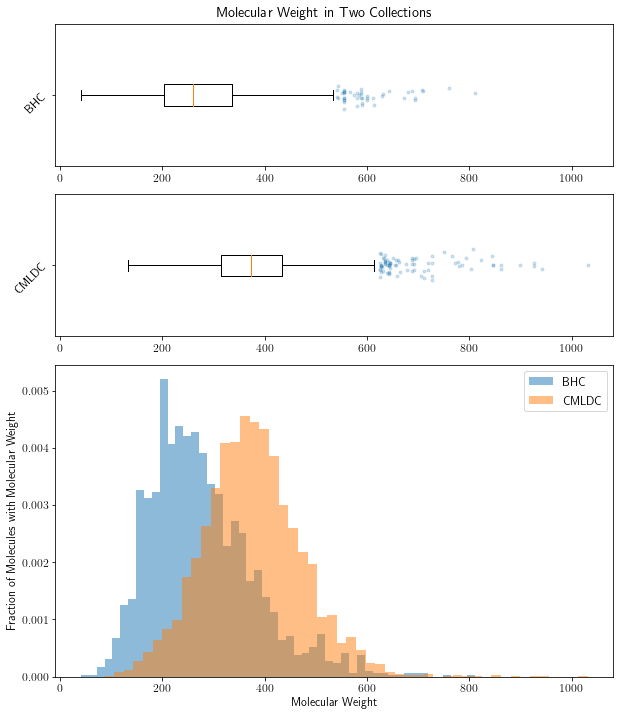

In [672]:
# Refresh the interface before preparing the figure
# Cheap as it does not regenerate libraries.
libraries = BurckData(poster, burck, cmld)
# Generate the figure
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
axs[0].xaxis.set_tick_params(which='both', labelbottom='True')
axs[1].xaxis.set_tick_params(which='both', labelbottom='True')
gs = axs[1].get_gridspec()
for ax in axs[2:]:
    ax.remove()
axbig = fig.add_subplot(gs[2:])
plt.suptitle("Molecular Weight in Two Collections", x=0.5, y=0.9)
libraries.getBoxplot('burck', 'weight', axs[0], mask_offset=200)
libraries.getBoxplot('cmld', 'weight', axs[1], mask_offset=190)
libraries.getHistogram(['burck', 'cmld'], 'weight', axbig,
                       alpha=0.5,
                       xlabel="Molecular Weight",
                       ylabel="Fraction of Molecules with Molecular Weight")
axbig.legend()
plt.savefig("weights.png")

In [673]:
###########################################
#                                         #
#    PIDGIN-Related Figures Start Here    #
#                                         #
###########################################

In [ ]:
test = pd.DataFrame(lines)
test.rename(columns=test.iloc[0]).drop(test.index[0])

In [3]:
lines2 = []
with open('gefitinib.txt', 'r') as f:
    for line in f:
        lines2.append(line)
for index, line in enumerate(lines2):
    lines2[index] = line.replace('\n', '').split('\t')
test2 = pd.DataFrame(lines2)
test2 = test2.rename(columns=test2.iloc[0]).drop(test2.index[0]).reset_index(drop=True)

In [4]:
test2 = test2.replace('nan', np.NaN)

In [8]:
test2 = test2.dropna()

In [ ]:
test2['']

In [13]:
test2['Compound_0_methyl'].sort_values()

0                    0.001
3387                 0.001
3315                 0.001
3298                 0.001
3296                 0.001
               ...        
4097    0.8777777777777778
148                    0.9
993                    0.9
3132    0.9222222222222223
5747    0.9333333333333333
Name: Compound_0_methyl, Length: 518, dtype: object

In [15]:
test2['Compound_0_propyl'].sort_values()

5954                 0.001
2111                 0.001
2137                 0.001
2149                 0.001
4169                 0.001
               ...        
3300    0.9111111111111111
148     0.9235294117647059
5747                 0.925
4736                 0.925
3938                  0.94
Name: Compound_0_propyl, Length: 518, dtype: object

In [8]:
test2 = test2.replace('nan', np.NaN)

In [9]:
test2['Vemurafenib'].dropna().sort_values()

138                  0.001
2813                 0.001
2814                 0.001
2815                 0.001
2816                 0.001
               ...        
2963    0.4461538461538462
2962    0.4461538461538462
2961    0.4461538461538462
2959    0.4461538461538462
2952    0.4461538461538462
Name: Vemurafenib, Length: 3935, dtype: object

In [ ]:
test2.sort_values(by='Activity_Threshold').reset_index(drop=True)

In [11]:
test2

,Uniprot,Name,Gene_ID,Protein_Classification,Organism,PDB_IDs,DisGeNET_0.06,ChEMBL_First_Publication,Activity_Threshold,Actives,...,Zanamivir,Zidovudine,Zileuton,Ziprasidone,Zoledronate,Zolmitriptan,Zolpidem,Zonisamide,Zopiclone,Zuclopenthixol
0,P28336,Neuromedin B receptor,4829,GPCR,Homo sapiens,N/A,Mammary Neoplasms,1996,1,62,...,nan,nan,nan,0.085,nan,nan,nan,nan,nan,nan
1,Q9Y3Q0,NAALADase II,10003,Protease,Homo sapiens,3FEC 3FED 3FEE 3FF3,N/A,2004,0.1,11,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,P23467,Receptor-type tyrosine-protein phosphatase beta,5787,Phosphatase,Homo sapiens,2AHS 2H02 2H03 2H04 2HC1 2HC2 2I3R 2I3U 2I4E 2...,Hemangiosarcoma,1999,10,126,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,P30419,Peptide N-myristoyltransferase 1,4836,Transferases,Homo sapiens,1RXT 3IU1 3IU2 3IWE 3JTK 4C2Y 4C2Z,N/A,1996,10,276,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,P30411,Bradykinin B2 receptor,624,GPCR,Homo sapiens,N/A,Rheumatoid Arthritis | Bipolar Disorder | Epil...,N/A,0.1,189,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4068,P62993,Growth factor receptor-bound protein 2,2885,Other,Homo sapiens,1AZE 1BM2 1BMB 1CJ1 1FHS 1FYR 1GCQ 1GFC 1GFD 1...,Schizophrenia,1995,0.1,59,...,nan,nan,nan,0.001,nan,nan,nan,nan,nan,nan
4069,Q16651,Prostasin,5652,Other,Homo sapiens,3DFJ 3DFL 3E0N 3E0P 3E16 3E1X 3FVF 3GYL 3GYM,Fetal Diseases | Neural Tube Defects | Placent...,2008,0.1,12,...,nan,nan,nan,0.001,nan,nan,nan,nan,nan,nan
4070,P39086,Glutamate receptor ionotropic kainate 1,2897,Ion_Channel,Homo sapiens,2ZNS 2ZNT 2ZNU 3FUZ 3FV1 3FV2 3FVG 3FVK 3FVN 3...,Alcoholic Intoxication | Alcoholic Intoxicatio...,2000,0.1,29,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4071,Q9NZQ8,Transient receptor potential cation channel su...,29850,Ion_Channel,Homo sapiens,N/A,N/A,2014,1,49,...,nan,nan,nan,0.001,nan,nan,nan,nan,nan,nan


In [4]:
drugs = pd.read_csv("drugs.txt", delimiter=r'\t+', engine='python')

In [ ]:
drugs

In [6]:
newdrugs = drugs.drop('cns_drug', axis=1).reset_index(drop=True)

In [7]:
cols = newdrugs.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols

['smiles', 'generic_name']

In [8]:
newdrugs = newdrugs[cols]

In [9]:
newdrugs

,smiles,generic_name
0,NC1=NC2=C(N=CN2[C@@H]2C[C@H](CO)C=C2)C(NC2CC2)=N1,Abacavir
1,None,Abarelix
2,None,Abatacept
3,None,Abciximab
4,CC(=O)O[C@H]1CC[C@]2(C)C3CC[C@@]4(C)C(CC=C4C4=...,Abiraterone
...,...,...
1686,CN(C)CCC1=CNC2=CC=C(C[C@H]3COC(=O)N3)C=C12,Zolmitriptan
1687,CN(C)C(=O)CC1=C(N=C2C=CC(C)=CN12)C1=CC=C(C)C=C1,Zolpidem
1688,NS(=O)(=O)CC1=NOC2=CC=CC=C12,Zonisamide
1689,CN1CCN(CC1)C(=O)OC1N(C(=O)C2=NC=CN=C12)C1=NC=C...,Zopiclone


In [10]:
newdrugs = newdrugs.dropna().reset_index(drop=True)

In [14]:
len(newdrugs['generic_name'].to_list())

1497

In [12]:
newdrugs.to_csv("drugs.smi", sep=' ', index=False)

In [12]:
rejected_smiles = []
total_processed = None
with open('drugs_cmdline_output.txt', 'r') as f:
    for line in f:
        tokenized_line = line.split(' ')
        if (len(tokenized_line) > 1) and (tokenized_line[1] == 'SMILES'):
            rejected_smiles.append(tokenized_line[-5])
        if (len(tokenized_line) > 1) and (tokenized_line[1] == 'Processing'):
            total_processed = tokenized_line[-1].strip('\n')
for index, line in enumerate(lines2):
    lines2[index] = line.replace('\n', '').split('\t')
test2 = pd.DataFrame(lines2)
test2.rename(columns=test2.iloc[0]).drop(test2.index[0])

NameError: name 'lines2' is not defined

In [10]:
total_processed

'1389'

In [18]:
test2 = test2.replace(['nan', np.NaN])

In [23]:
test2['Abiraterone']

3453                 0.001
1889                 0.001
1890                 0.001
1891                 0.001
1892                 0.001
               ...        
392     0.9642857142857143
393     0.9642857142857143
394     0.9642857142857143
387     0.9642857142857143
451     0.9642857142857143
Name: Abiraterone, Length: 4040, dtype: object

In [33]:
test2.iloc[392]

Uniprot                                        P16591
Name                      Tyrosine-protein kinase FER
Gene_ID                                          2241
Protein_Classification                         Kinase
Organism                                 Homo sapiens
                                     ...             
Zolmitriptan                      0.03333333333333333
Zolpidem                         0.027777777777777776
Zonisamide                                      0.001
Zopiclone                                         nan
Zuclopenthixol                                  0.001
Name: 392, Length: 1405, dtype: object

In [128]:
test4

1       nan
2       nan
3       nan
4       nan
5       nan
       ... 
4069    nan
4070    nan
4071    nan
4072    nan
4073    nan
Name: Sirolimus, Length: 4073, dtype: object

In [257]:
import rdkit.Chem.Draw

In [264]:
Chem.Draw.MolToFile(Chem.MolFromSmiles('COC1=C(OCCCN2CCOCC2)C(C)=C2C(NC3=CC(Cl)=C(F)C=C3)=NC=NC2=C1'), "noact.png")

In [462]:
tpconf = pd.read_csv("target_prediction_confidence.csv")

In [524]:
fda = tpconf.loc[tpconf['Collection'] == 'FDA']
bhc = tpconf.loc[tpconf['Collection'] == 'BHC']
cmld = tpconf.loc[tpconf['Collection'] == 'CMLD']

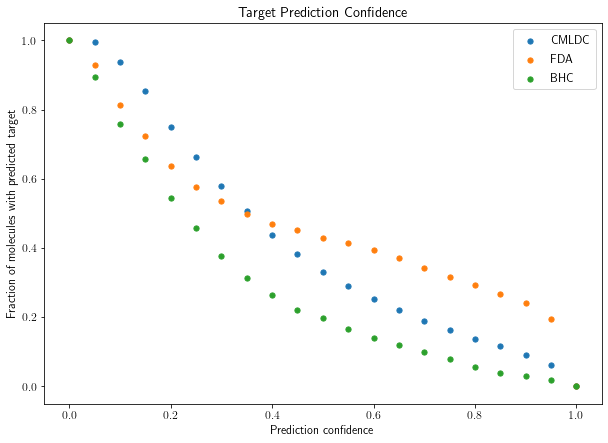

In [549]:
fig, ax = plt.subplots(figsize=(10,7))
plt.title("Target Prediction Confidence")
plt.scatter(s=27, x=cmld['confidence'], y=cmld['value'], label='CMLDC')
plt.scatter(s=27, x=fda['confidence'], y=fda['value'], label='FDA')
plt.scatter(s=27, x=bhc['confidence'], y=bhc['value'], label='BHC')
plt.ylabel("Fraction of molecules with predicted target")
plt.xlabel("Prediction confidence")
ax.legend()
plt.savefig("tpconf.png", dpi=150)
plt.show()

In [555]:
import sys
sys.version

'3.8.1 (default, Jan  8 2020, 22:29:32) \n[GCC 7.3.0]'